# Линеаризация признаков на базе WoE (Weight of Evidence) в моделях бинарной классификации. Отчет

## Генерирование данных

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=7000, n_features=20, n_informative=5, n_redundant=2,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5, 
                           random_state=40)

Разбивка на train и test

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Визуализация данных

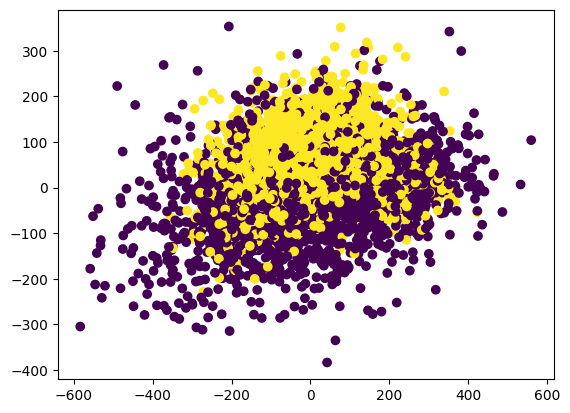

In [3]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

Первично анализировать признаки удобно с помощью woe_line.

Функция делит наблюдения на группы по $X$, для каждой группы считает WoE, и откладывает эти значения на графике.

Можно встретить определение WoE, отличающееся знаком, на анализ и выводы это не влияет

# Анализ данных

## Подготовка

Создадим функцию woe_line, которая:

1. разбивает наблюдения на n_buckets групп по $X$
2. в каждой группе по y откладывает WoE, по x медианное значение $X$
3. выводит полученный график
4. выводит ROC AUC признака 
5. рассчитывает доверительный интервал для bad rate (bad rate - доля наблюдений с целевой переменной =1 от всех наблюдений в группе)
6. нанести на график линейное приближение

In [4]:
import pandas as pd
from sklearn.metrics import roc_auc_score

In [5]:
def woe_line(X,         # 1-d array with independent feature 
             y,         # 1-d array with target feature
             n_buckets, # number of buckets to plot
             var_nm,    # optional, var_name to show above the plot
             target_nm, # optional, target_name to show above the plot
             plot_hist  # optional, if True — histogram of X is displayed
            ):
    # calculate woe values for buckets
    p1_all = sum(y)/len(y)     # p1 for all samples
    p0_all = 1-p1_all          # p0 for all samples
    all = np.log(p1_all/p0_all)
    df = pd.DataFrame(X, columns=['feature'])
    df['y'] = y
    df = df.groupby(['feature'], as_index=False).median()
    labels = [x for x in range(n_buckets)]
    df['interval'] = pd.qcut(df['feature'], q=n_buckets, labels=labels, duplicates='drop')
    x_coord = np.zeros(n_buckets)    
    woe = np.zeros(n_buckets)
    bad_rate = np.zeros(n_buckets)
    for i in range(n_buckets):
        bucket = df[df.interval == i]
        x_coord[i] = np.median(bucket.feature)
        p1 = sum(bucket.y) / len(bucket.index)
        p0 = 1 - p1
        woe[i] = p1/p0
        bad_rate[i] = p1
    woe = np.log(woe) - all
    # calculate ROC-AUC for feature
    auc = roc_auc_score(df.y, df.feature)
    # confidence interval for bad rate (confidence level = 0.95)
    left = np.mean(bad_rate) - 1.96 * (np.std(bad_rate) / (n_buckets ** 0.5))
    right = np.mean(bad_rate) + 1.96 * (np.std(bad_rate) / (n_buckets ** 0.5))
    err = (right - left) / 2
    # plot woe
    plt.errorbar(x_coord, woe, yerr=err, fmt='or--', label='WoE ')
    # linear approximation of woe-plot
    A = np.vstack([x_coord, np.ones(n_buckets)]).T
    m, c = np.linalg.lstsq(A, woe, rcond=None)[0]
    plt.plot(x_coord, m*x_coord + c, 'b', label='Interpolation')
    plt.title(f'{var_nm} | {target_nm}   AUC = {round(auc, 3)}   Bad_rate: [{round(left,3)}, {round(right, 3)}]')
    plt.legend()
    plt.show()
    if plot_hist==True:
        plt.title(f'Histogram of {var_nm}') 
        plt.hist(df.feature)
    plt.show()

## Анализ каждой переменной

Проверим каждую переменную на woe_line.

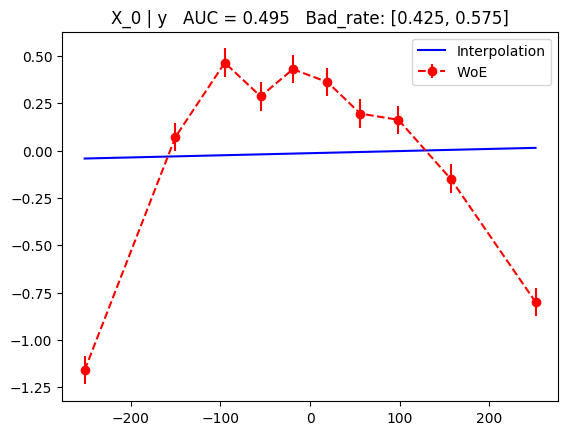

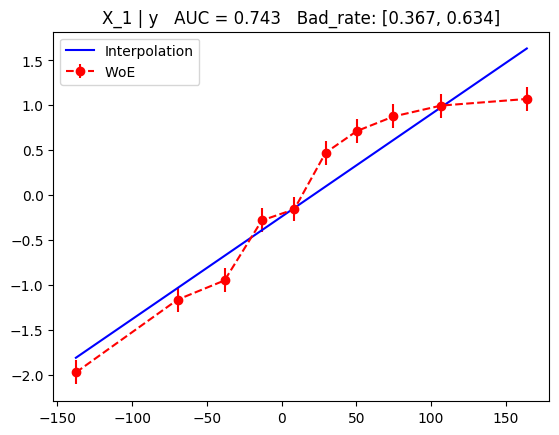

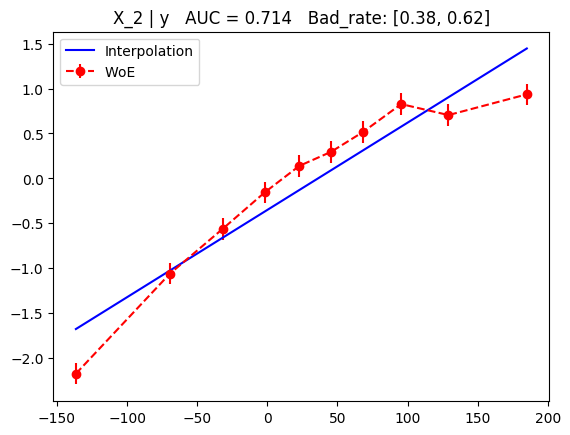

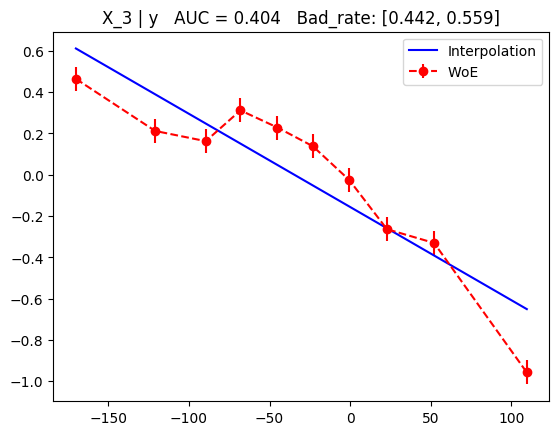

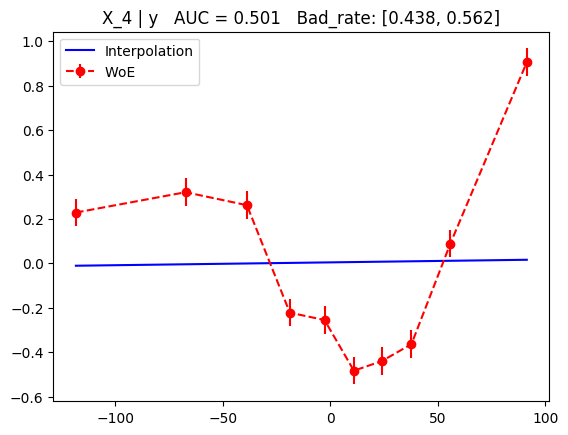

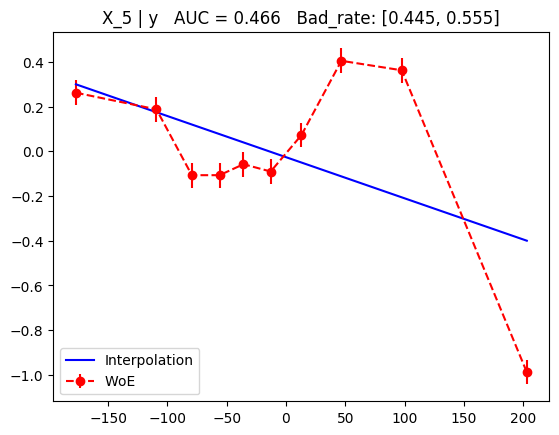

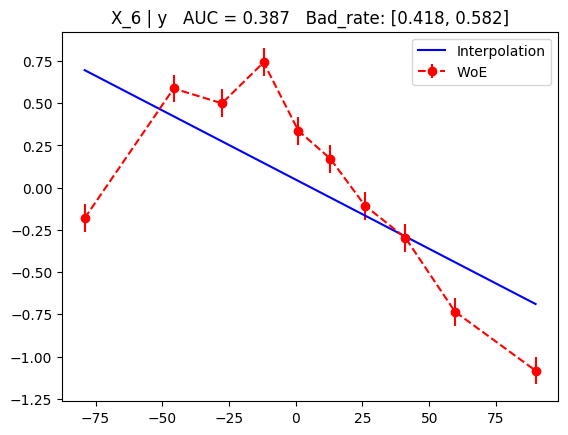

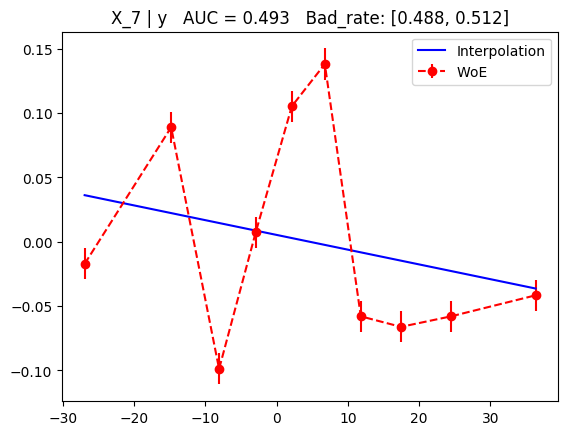

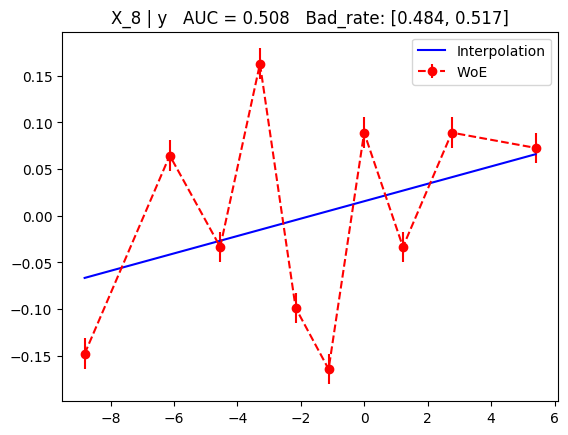

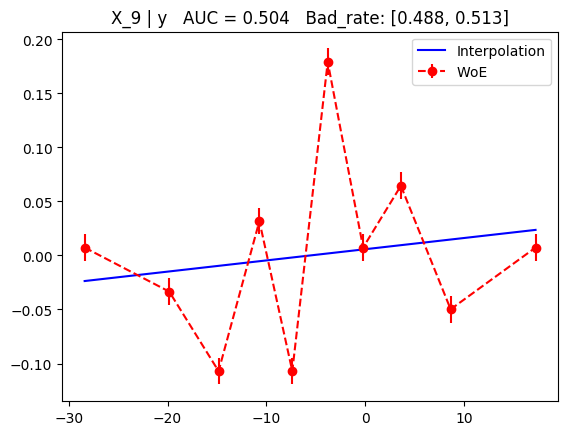

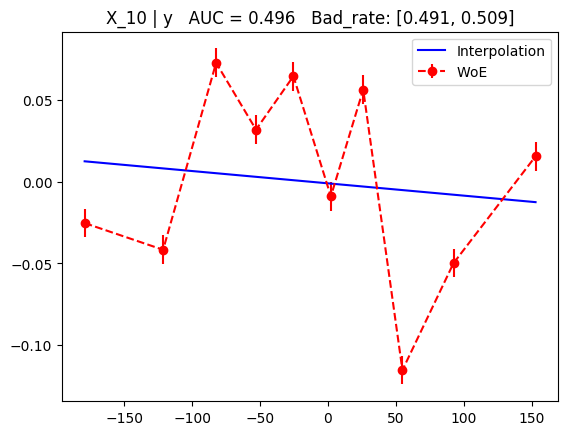

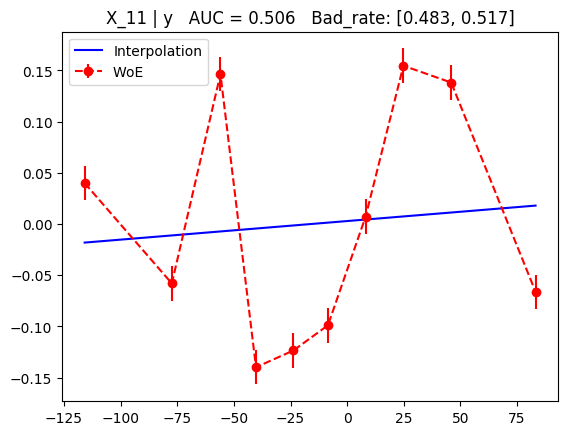

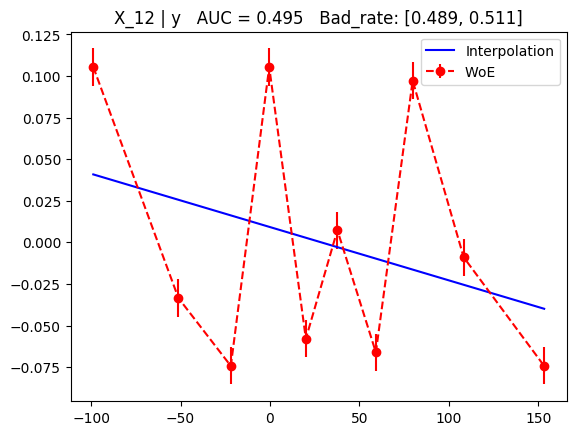

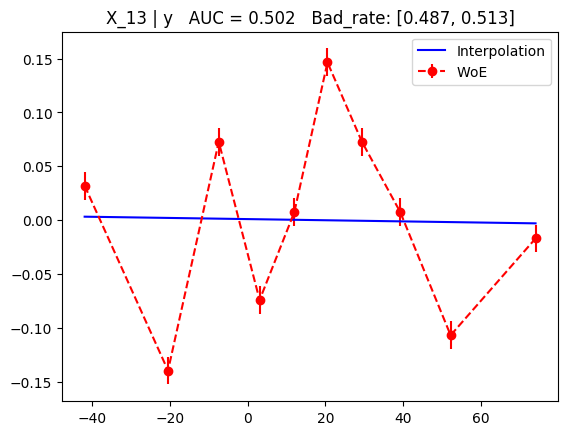

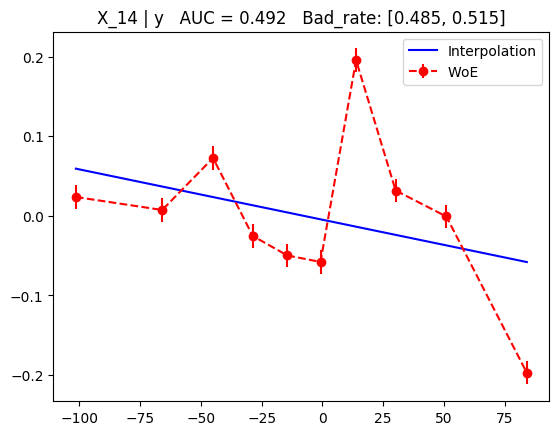

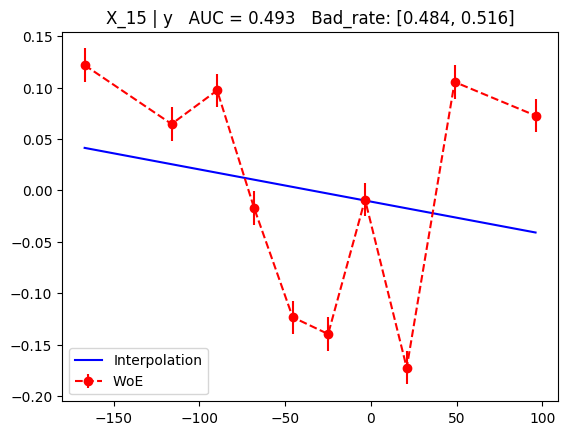

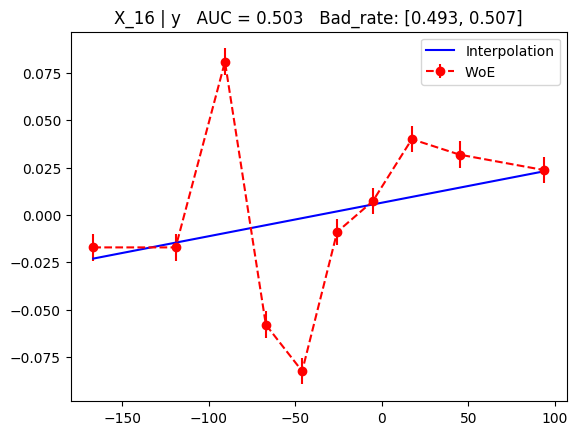

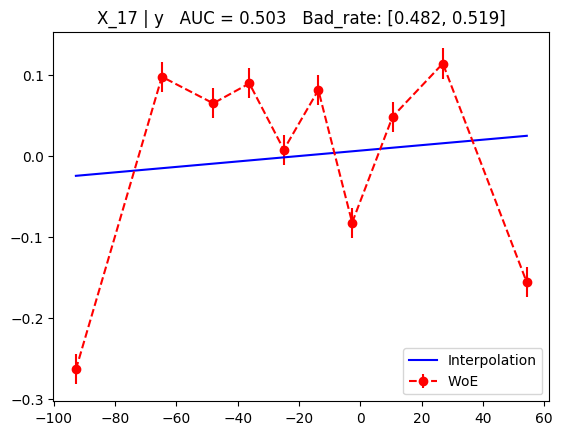

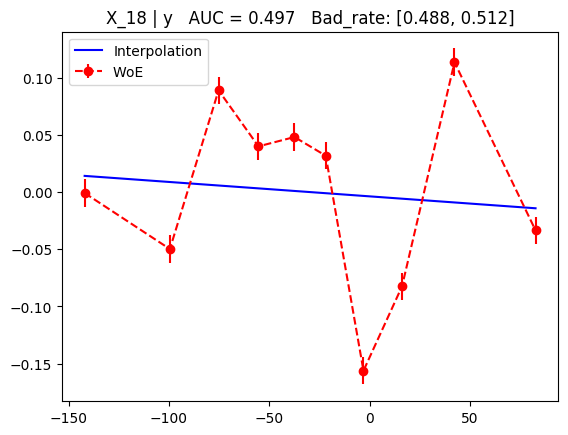

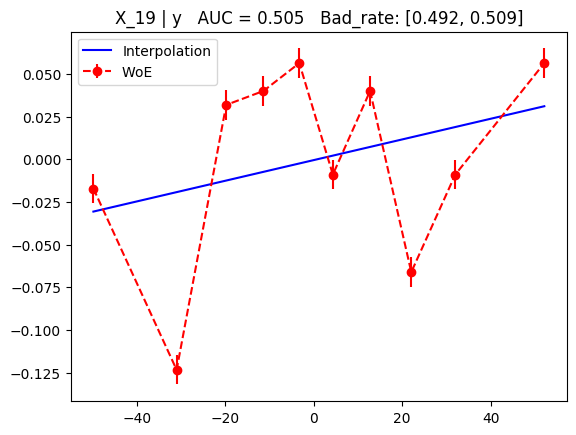

In [8]:
# plot woe_lines for all features
for i in range(X_train.shape[1]):
    woe_line(X_train[:, i], y_train, n_buckets=10, plot_hist=False, 
               var_nm = f'X_{i}', target_nm = 'y')

Из построенных графиков видно, что все переменные требуют линеаризации, но не все из них информативные. Поэтому определим полезные переменные и будем линеаризовать именно их.

In [9]:
# find informative features

non_informative = []

for i in range(X_train.shape[1]):
    auc = roc_auc_score(y_train, X_train[:, i])

    if abs(auc - 0.5) < 0.02:
        print(f"{i} : {auc = :.3f} -> non_informative")
        non_informative.append(i)

    else:
        print(f"{i} : {auc = :.3f}")

0 : auc = 0.495 -> non_informative
1 : auc = 0.743
2 : auc = 0.714
3 : auc = 0.404
4 : auc = 0.501 -> non_informative
5 : auc = 0.466
6 : auc = 0.387
7 : auc = 0.493 -> non_informative
8 : auc = 0.508 -> non_informative
9 : auc = 0.504 -> non_informative
10 : auc = 0.496 -> non_informative
11 : auc = 0.506 -> non_informative
12 : auc = 0.495 -> non_informative
13 : auc = 0.502 -> non_informative
14 : auc = 0.492 -> non_informative
15 : auc = 0.493 -> non_informative
16 : auc = 0.503 -> non_informative
17 : auc = 0.503 -> non_informative
18 : auc = 0.497 -> non_informative
19 : auc = 0.505 -> non_informative


Для дальнейшенго удобства создадим датафрейм из X_train и y_train

In [10]:
df_train = pd.DataFrame(X_train)
df_train['y']= y_train

In [11]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,y
0,-103.311082,51.778931,9.805069,-52.472192,-105.656211,99.466342,-34.678814,-5.455000,5.129902,-0.450759,...,-58.015974,-25.162511,21.085145,14.269830,-93.329542,-68.947838,-1.095961,-61.755959,17.427817,1
1,-253.185817,51.752425,70.699646,-151.386583,0.469714,-17.417257,51.352211,-20.265163,-9.661917,-15.114604,...,-5.208167,35.141001,-0.188534,157.763181,-184.256850,-7.165808,-23.678420,88.557107,23.594175,1
2,-107.526900,38.411604,152.431738,2.127607,79.290923,-43.846379,-0.817466,4.109129,-0.735800,-39.237217,...,31.429558,70.167374,16.981131,7.835781,61.972403,35.815927,42.912450,-115.105558,18.267884,1
3,153.109292,130.338572,105.312877,-117.580249,58.688983,-173.840548,33.360543,-4.157136,-4.099493,-27.734150,...,-34.510893,52.371481,41.548186,11.780563,5.339953,-49.651188,78.349211,-6.859514,38.954888,1
4,-99.905530,78.226655,182.365916,22.282025,67.290909,-33.820175,-30.849742,11.173439,-1.409730,-4.668511,...,-14.088290,57.320788,46.705398,-22.961663,174.516892,47.180371,-93.033152,-71.078030,-24.160750,1


Таким образом, полезные переменные содержатся в колонках матрицы с индексами 1, 2, 3, 5 и 6. Проверим их попарный коэффициент корреляции

In [12]:
df_train[[1, 2, 3, 5, 6]].corr()

,1,2,3,5,6
1,1.000000,-0.052771,0.032740,-0.592789,-0.271102
2,-0.052771,1.000000,-0.172888,0.365322,-0.300744
3,0.032740,-0.172888,1.000000,0.085671,-0.649468
5,-0.592789,0.365322,0.085671,1.000000,-0.443730
6,-0.271102,-0.300744,-0.649468,-0.443730,1.000000


Переменная 6 сильно зависит от переменных 2, 3 и 5. Переменная 5 также зависит от переменных 1 и 2. Можно исключить данные переменные, но попробуем при построении моделей решить проблему мультиколлениарности путем применения регуляризации.

Нормализуем полезные перемнные (приведем к отрезку [0, 1])

In [13]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_train[[1, 2, 3, 5, 6]] = min_max_scaler.fit_transform(df_train[[1, 2, 3, 5, 6]])

Теперь рассмотрим полезные переменные поочередно и линеаризуем их

### Переменная X_train[:, 1]

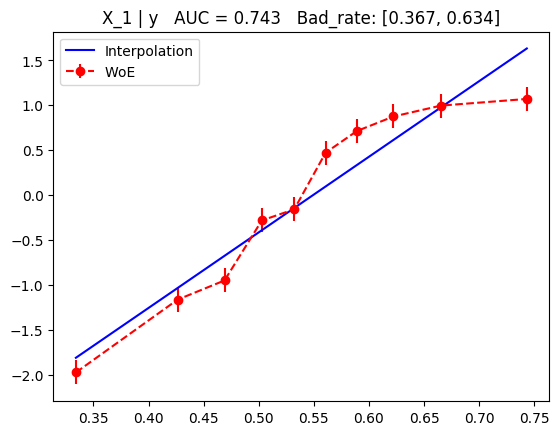

In [14]:
# plot before transformation
woe_line(df_train[1].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{1}', target_nm = 'y')

Применим clip, чтобы "выровнять" последний бакет. Приблизить отдельные точки к линейной аппроксимации можно, взяв квадратный корень из переменной

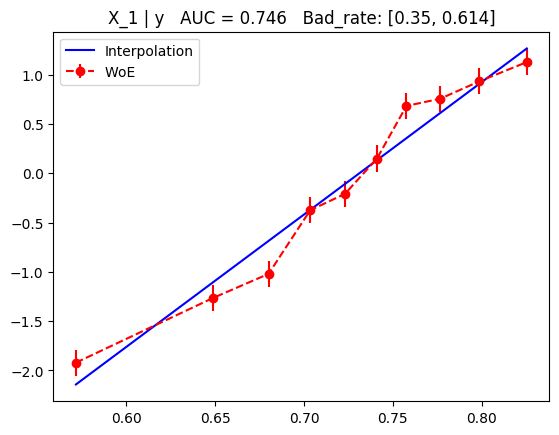

In [15]:
# after transformation
df_train1 = df_train.copy()
df_train1[[1]] = np.clip(df_train1[[1]], 0, 0.72)  ** 0.5
woe_line(df_train1[1].values, df_train1.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{1}', target_nm = 'y')

### Переменная X_train[:, 2]

Будем рассматрвать переменную X_train[:, 2] с учетом органичений, наложенных на X_train[:, 1]

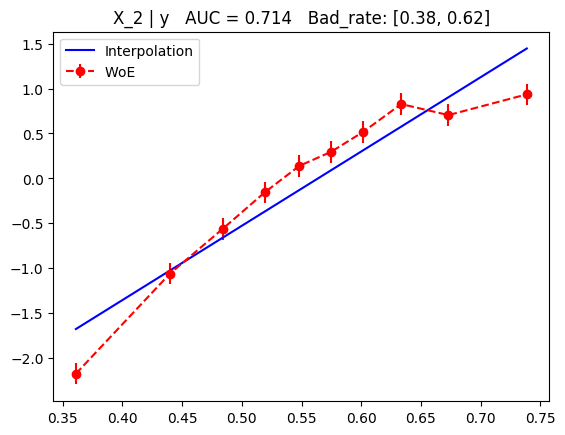

In [16]:
# plot before transformation
woe_line(df_train[2].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{2}', target_nm = 'y')

В целом переменная достаточно хорошо приближается линейной зависимостью. Применим clip, чтобы "выровнять" последний бакет. Приблизить отдельные точки к линейной аппоксимации можно, возведя переменную в степень 1/8

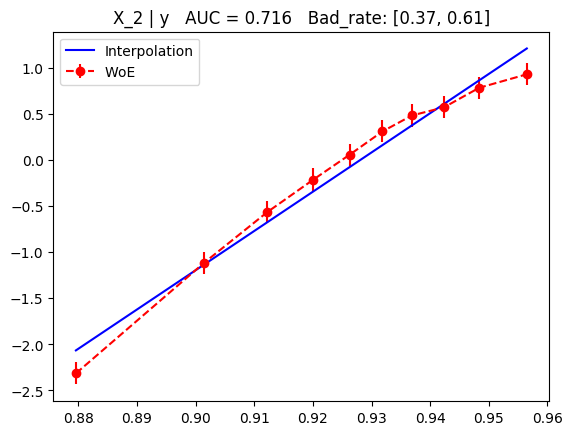

In [17]:
# after transformation
df_train2 = df_train1.copy()
df_train2[[2]] = np.clip(df_train2[[2]], 0, 0.74) ** (0.125)
woe_line(df_train2[2].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{2}', target_nm = 'y')

### Переменная X_train[:, 3]

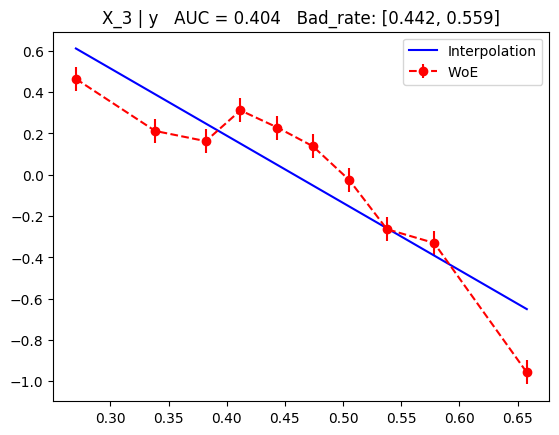

In [18]:
# plot before transformation
woe_line(df_train[3].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{3}', target_nm = 'y')

В данном случае попробуем применить преобразование х**3, и потом выравняем крайний левый бакет

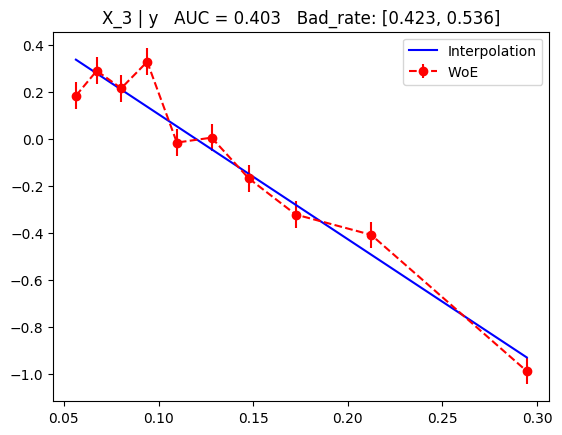

In [19]:
# after transformation
df_train3 = df_train2.copy()
df_train3[[3]] = np.clip(df_train3[[3]] ** 3, 0.05, 0.5)
woe_line(df_train3[3].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{3}', target_nm = 'y')

### Переменная X_train[:, 5]

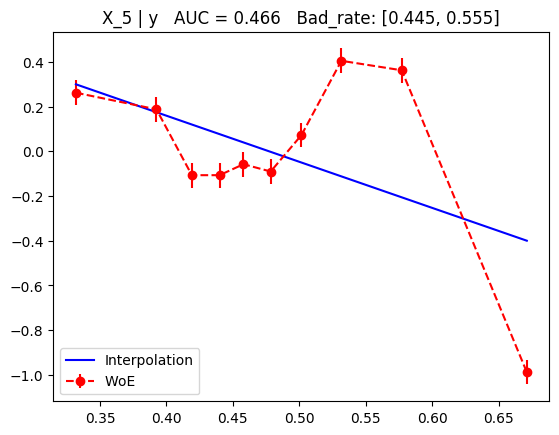

In [20]:
# plot before transformation
woe_line(df_train[5].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{5}', target_nm = 'y')

Данная переменная плохо линеаризуется. Особую проблему создает резкое падение значения woe на последнем бакете. Поэтому применим фукнцию clip и возведем переменную в квадрат, чтобы снизить размах ее колебаний.

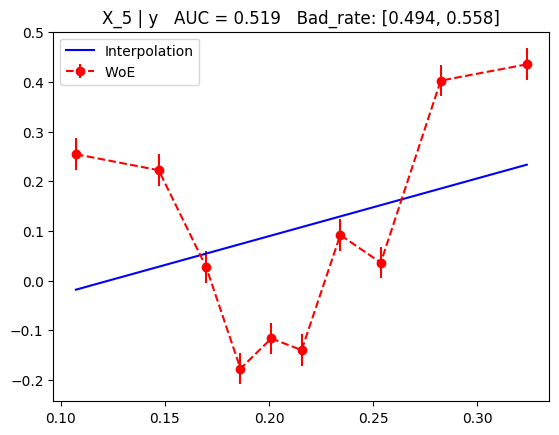

In [21]:
# after transformation
df_train5 = df_train3.copy()
df_train5[[5]] = np.clip(df_train5[[5]], 0, 0.6) ** 2
woe_line(df_train5[5].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{5}', target_nm = 'y')

### Переменная X_train[:, 6]

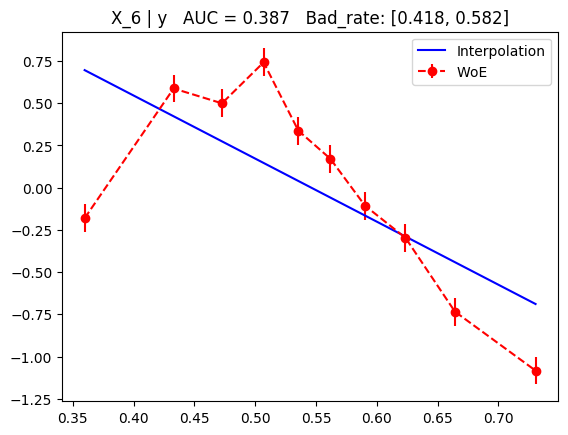

In [22]:
# plot before transformation
woe_line(df_train[6].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{6}', target_nm = 'y')

Применим clip, чтобы выровнять первый бакет и возведем в квадрат

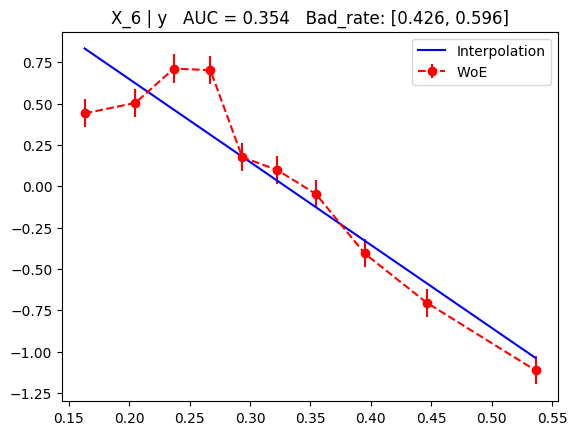

In [23]:
# after transformation
df_train6 = df_train5.copy()
df_train6[[6]] = np.clip(df_train6[[6]], 0.36, 0.9) ** 2
woe_line(df_train6[6].values, df_train.y.values, n_buckets=10, plot_hist=False, var_nm = f'X_{6}', target_nm = 'y')

Соберем все выполненные преобразования по линеаризации свойств в функцию

In [24]:
def transformation(df):
    # transformation of feature matrix
    df[[1]] = np.clip(df[[1]], 0, 0.72) ** 0.5
    df[[2]] = np.clip(df[[2]], 0, 0.74) ** 0.125
    df[[3]] = np.clip(df[[3]] ** 3, 0.05, 0.5)
    df[[5]] = np.clip(df[[5]], 0, 0.6) ** 2
    df[[6]] = np.clip(df[[6]], 0.36, 0.9) ** 2
    return df

# Модель логистической регрессии с регуляризацией и кросс-валидацией

In [25]:
from sklearn.linear_model import LogisticRegressionCV

Строим модель логистической регрессии с L2-регуляризацией и кросс-валидацией

In [26]:
logreg = LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001], scoring='roc_auc', refit=True, max_iter=500, cv=5, penalty='l2')

Сначала посмотрим, какой результат модель покажет на "сырых" данных

In [27]:
model1 = logreg.fit(X_train, y_train)

In [28]:
y_pred = model1.predict(X_test)
print ('Max roc_auc on test dataset:', round(roc_auc_score(y_test, y_pred), 3))

Max roc_auc on test dataset: 0.739


Теперь построим модель на нормализованных и отобранных (информативных) признаках

In [29]:
model2 = logreg.fit(df_train[[1, 2, 3, 5, 6]], df_train.y)

In [30]:
df_test = pd.DataFrame(X_test)
df_test['y']= y_test
df_test[[1, 2, 3, 5, 6]] = min_max_scaler.transform(df_test[[1, 2, 3, 5, 6]])

In [31]:
y_pred = model2.predict(df_test[[1, 2, 3, 5, 6]])
print ('Max roc_auc on test dataset:', round(roc_auc_score(df_test.y, y_pred), 3))

Max roc_auc on test dataset: 0.738


Наблюдаем незначительное падение roc-auc score, но модель при этом значительно упростилась (вместо 20 признаков в ней учитывается 5).

Теперь построим модель на отобранных признаках после их линеаризации

In [32]:
model3 = logreg.fit(df_train6[[1, 2, 3, 5, 6]], df_train6.y)

In [33]:
df_test3 = transformation(df_test)

In [34]:
y_pred = model3.predict(df_test[[1, 2, 3, 5, 6]])
print ('Max roc_auc on test dataset:', round(roc_auc_score(df_test.y, y_pred), 3))

Max roc_auc on test dataset: 0.758


Как видим, линеаризация отобранных признаков позволила улучшить качество модели

# Построение случайного леса

### Случайный лес на сырых данных

Построим валидационную выборку

In [35]:
X_forest_full_train, X_forest_test, y_forest_full_train, y_forest_test = train_test_split(
                                                                        X, y, test_size=0.2, random_state=0)
X_forest_train, X_forest_val, y_forest_train, y_forest_val = train_test_split(
                                                            X_forest_full_train, y_forest_full_train, 
                                                            test_size=0.25, random_state=0)

In [36]:
from sklearn.ensemble import RandomForestClassifier

Посмотрим качество модели, которое получается без подбора гиперпараметров

In [37]:
rf1 = RandomForestClassifier(random_state=1)
rf1.fit(X_forest_train, y_forest_train)

y_pred = rf1.predict_proba(X_forest_val)[:, 1]
print ('Roc_auc on val dataset:', round(roc_auc_score(y_forest_val, y_pred), 3))

Roc_auc on val dataset: 0.937


Выполним подбор параметров n_estimators, max_depth и min_sample_leaf

Сначала рассмотрим, как изменяется значение roc_auc при различных величинах max_depth

In [38]:
scores = []

for d in range(9, 25, 3):
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_forest_train, y_forest_train)

        y_pred = rf.predict_proba(X_forest_val)[:, 1]
        auc = roc_auc_score(y_forest_val, y_pred)

        scores.append((d, n, auc))

In [39]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

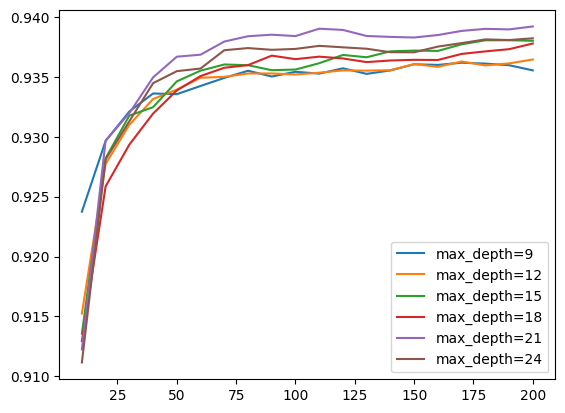

In [40]:
for d in range(9, 25, 3):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Из полученных графиков видно, что roc_auc достигает наибольшего значения при max_depth=21. Теперь выполним подбор наилучшего значения min_samples_leaf

In [41]:
scores = []

for s in [1, 3, 5, 7]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=21,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_forest_train, y_forest_train)

        y_pred = rf.predict_proba(X_forest_val)[:, 1]
        auc = roc_auc_score(y_forest_val, y_pred)

        scores.append((s, n, auc))

In [42]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

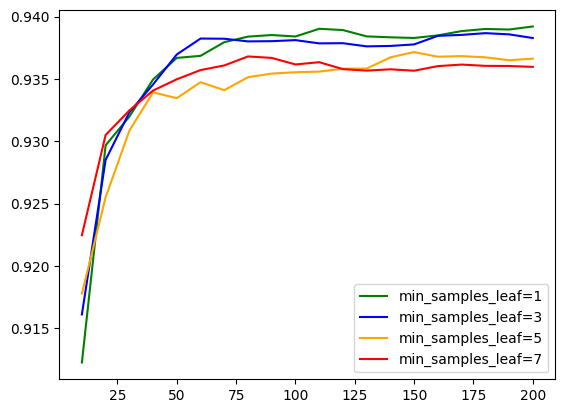

In [43]:
colors = ['green', 'blue', 'orange', 'red']
values = [1, 3, 5, 7]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

Видим, что наибольшая величина roc_auc достигается при min_samples_leaf=1. Локальный максимум получаем при количестве деревьев между 100 и 120. Определим оптимальное количество деревьев

In [44]:
scores = []

for n in range(100, 120, 1):
    rf = RandomForestClassifier(n_estimators=n,
                                max_depth=21,
                                min_samples_leaf=1,
                                random_state=1)
    rf.fit(X_forest_train, y_forest_train)

    y_pred = rf.predict_proba(X_forest_val)[:, 1]
    auc = roc_auc_score(y_forest_val, y_pred)
    
    scores.append((n, auc))

In [45]:
scores

[(100, 0.9384030239758668),
 (101, 0.9382979114237955),
 (102, 0.9385275262220099),
 (103, 0.9386510079579385),
 (104, 0.9385428338752243),
 (105, 0.9386959104073672),
 (106, 0.9388704176540104),
 (107, 0.9387510179589387),
 (108, 0.9390326787780819),
 (109, 0.9390316582678676),
 (110, 0.9390194121452962),
 (111, 0.9391561605140105),
 (112, 0.9391949399021534),
 (113, 0.9392224936779391),
 (114, 0.9391571810242247),
 (115, 0.9391071760237247),
 (116, 0.9391265657177962),
 (117, 0.9390602325538676),
 (118, 0.9391561605140106),
 (119, 0.939029617247439)]

Оптимальное количество деревьев n_estimators=113. Построим окончательную модель и рассчитаем roc-auc score

In [46]:
rf2 = RandomForestClassifier(n_estimators=113,
                             max_depth=21,
                             min_samples_leaf=1,
                             random_state=1)
rf2.fit(X_forest_train, y_forest_train)

y_pred = rf2.predict_proba(X_forest_val)[:, 1]
print ('Roc_auc on val dataset:', round(roc_auc_score(y_forest_val, y_pred), 3))

Roc_auc on val dataset: 0.939


Получили гиперпараметры, при которых roc-auc score чуть выше, чем в модели случайного леса, построенной по умолчанию. Посмотрим результат работы данной модели на тестовом датасете (после обучения на train+val датасете)

In [47]:
rf2 = RandomForestClassifier(n_estimators=113,
                             max_depth=21,
                             min_samples_leaf=1,
                             random_state=1)
rf2.fit(X_forest_full_train, y_forest_full_train)

y_pred = rf2.predict_proba(X_forest_test)[:, 1]
print ('Roc_auc on test dataset:', round(roc_auc_score(y_forest_test, y_pred), 3))

Roc_auc on test dataset: 0.928


roc-auc score снизился, но все равно остался высоким по сравнению с линейной моделью.

### Случайный лес на обработанных данных

Создадим датафреймы для обучающей, валидационной и тестовой выборок на отобранных признаках

In [48]:
df_forest_train = pd.DataFrame(X_forest_train[:, 1:4], columns=['1', '2', '3'])
df_forest_train['5'] = X_forest_train[:, 5]
df_forest_train['6'] = X_forest_train[:, 6]
df_forest_train['y'] = y_forest_train

In [49]:
df_forest_val = pd.DataFrame(X_forest_val[:, 1:4], columns=['1', '2', '3'])
df_forest_val['5'] = X_forest_val[:, 5]
df_forest_val['6'] = X_forest_val[:, 6]
df_forest_val['y'] = y_forest_val

In [50]:
df_forest_test = pd.DataFrame(X_forest_test[:, 1:4], columns=['1', '2', '3'])
df_forest_test['5'] = X_forest_test[:, 5]
df_forest_test['6'] = X_forest_test[:, 6]
df_forest_test['y'] = y_forest_test

In [51]:
df_forest_full_train = pd.DataFrame(X_forest_full_train[:, 1:4], columns=['1', '2', '3'])
df_forest_full_train['5'] = X_forest_full_train[:, 5]
df_forest_full_train['6'] = X_forest_full_train[:, 6]
df_forest_full_train['y'] = y_forest_full_train

Алгоритмы, основанные на деревьях считаются нечувствительными к нормировке, но поскольку построенные выше преобразования по линеаризации признаков, применяются к отнормированным признакам, применим нормировку

In [52]:
min_max_scaler = MinMaxScaler()
df_forest_train[['1', '2', '3', '5', '6']] = min_max_scaler.fit_transform(df_forest_train[['1', '2', '3', '5', '6']])
df_forest_val[['1', '2', '3', '5', '6']] = min_max_scaler.transform(df_forest_val[['1', '2', '3', '5', '6']])
df_forest_test[['1', '2', '3', '5', '6']] = min_max_scaler.transform(df_forest_test[['1', '2', '3', '5', '6']])
df_forest_full_train[['1', '2', '3', '5', '6']] = min_max_scaler.transform(df_forest_full_train[['1', '2', '3', '5', '6']])

Линеаризуем признаки

In [53]:
def transformation2(df):
    # transformation of feature matrix
    df[['1']] = np.clip(df[['1']], 0, 0.72) ** 0.5
    df[['2']] = np.clip(df[['2']], 0, 0.74) ** 0.125
    df[['3']] = np.clip(df[['3']] ** 3, 0.05, 0.5)
    df[['5']] = np.clip(df[['5']], 0, 0.6) ** 2
    df[['6']] = np.clip(df[['6']], 0.36, 0.9) ** 2
    return df

In [54]:
df_forest_train = transformation2(df_forest_train)
df_forest_val = transformation2(df_forest_val)
df_forest_test = transformation2(df_forest_test)
df_forest_full_train = transformation2(df_forest_full_train)

По аналогии с моделью, построенной на сырых данных, посмотрим качество модели, которое получается без подбора гиперпараметров

In [55]:
rf3 = RandomForestClassifier(random_state=1)
rf3.fit(df_forest_train[['1', '2', '3', '5', '6']], df_forest_train.y)

y_pred = rf3.predict_proba(df_forest_val[['1', '2', '3', '5', '6']])[:, 1]
print ('Roc_auc on val dataset:', round(roc_auc_score(df_forest_val.y, y_pred), 3))

Roc_auc on val dataset: 0.92


Получили, что на обработанных данных без подбора гиперпараметров roc_auc score ниже (составил 0,92), чем на сырых (равен 0,937). 

Выполним для модели, построенной на обработанных данных, подбор гиперпараметров: n_estimators, max_depth и min_sample_leaf

Сначала рассмотрим, как изменяется значение roc_auc при различных величинах max_depth

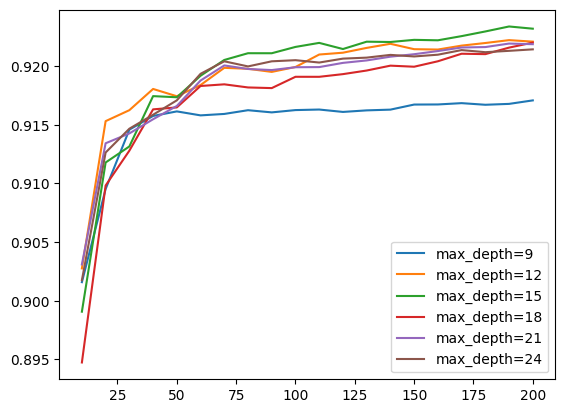

In [56]:
scores = []

for d in range(9, 25, 3):
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(df_forest_train[['1', '2', '3', '5', '6']], df_forest_train.y)

        y_pred = rf.predict_proba(df_forest_val[['1', '2', '3', '5', '6']])[:, 1]
        auc = roc_auc_score(df_forest_val.y, y_pred)

        scores.append((d, n, auc))
        
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in range(9, 25, 3):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

Из полученных графиков видно, что roc_auc достигает наибольшего значения при max_depth=15. Теперь выполним подбор наилучшего значения min_samples_leaf

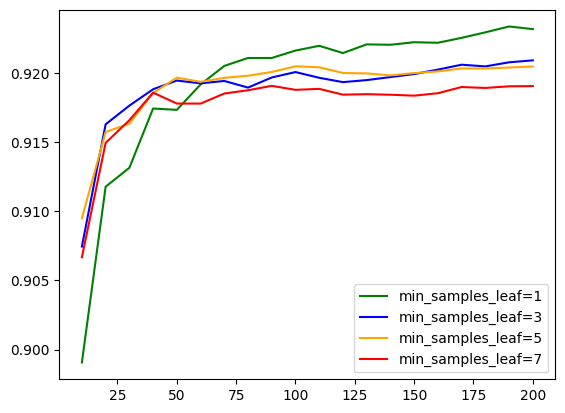

In [57]:
scores = []

for s in [1, 3, 5, 7]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=15,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(df_forest_train[['1', '2', '3', '5', '6']], df_forest_train.y)

        y_pred = rf.predict_proba(df_forest_val[['1', '2', '3', '5', '6']])[:, 1]
        auc = roc_auc_score(df_forest_val.y, y_pred)

        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['green', 'blue', 'orange', 'red']
values = [1, 3, 5, 7]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

Видим, что, как и в случае с сырыми данными, наибольшая величина roc_auc достигается при min_samples_leaf=1. Локальный максимум получаем при количестве деревьев между 180 и 200. Определим оптимальное количество деревьев

In [58]:
scores = []

for n in range(180, 200, 1):
    rf = RandomForestClassifier(n_estimators=n,
                                max_depth=15,
                                min_samples_leaf=1,
                                random_state=1)
    rf.fit(df_forest_train[['1', '2', '3', '5', '6']], df_forest_train.y)

    y_pred = rf.predict_proba(df_forest_val[['1', '2', '3', '5', '6']])[:, 1]
    auc = roc_auc_score(df_forest_val.y, y_pred)
    
    scores.append((n, auc))

scores

[(180, 0.922956581372423),
 (181, 0.9231566013744231),
 (182, 0.9232413037222089),
 (183, 0.9232515088243518),
 (184, 0.9232494678039231),
 (185, 0.923209667905566),
 (186, 0.9232147704566376),
 (187, 0.9232484472937089),
 (188, 0.9233239650495662),
 (189, 0.9233300881108519),
 (190, 0.9233811136215663),
 (191, 0.9232943702533519),
 (192, 0.9234168314790662),
 (193, 0.923398462295209),
 (194, 0.9233770315807092),
 (195, 0.9232841651512089),
 (196, 0.9232800831103518),
 (197, 0.9232402832119947),
 (198, 0.9232270165792089),
 (199, 0.9232392627017804)]

Оптимальное количество деревьев n_estimators=192. Построим окончательную модель и рассчитаем roc-auc score

In [59]:
rf4 = RandomForestClassifier(n_estimators=192,
                             max_depth=15,
                             min_samples_leaf=1,
                             random_state=1)
rf4.fit(df_forest_train[['1', '2', '3', '5', '6']], df_forest_train.y)

y_pred = rf.predict_proba(df_forest_val[['1', '2', '3', '5', '6']])[:, 1]
print ('Roc_auc on val dataset:', round(roc_auc_score(df_forest_val.y, y_pred), 3))

Roc_auc on val dataset: 0.923


Подбор гиперпараметров позволил незначительно улучшить показатель roc_auc (на 0,003), но он остался ниже, чем у модели, построенной на сырых данных. Посмотрим результат работы данной модели на тестовом датасете (после обучения на train+val датасете)

In [60]:
rf4 = RandomForestClassifier(n_estimators=192,
                             max_depth=15,
                             min_samples_leaf=1,
                             random_state=1)
rf4.fit(df_forest_full_train[['1', '2', '3', '5', '6']], df_forest_full_train.y)

y_pred = rf.predict_proba(df_forest_test[['1', '2', '3', '5', '6']])[:, 1]
print ('Roc_auc on test dataset:', round(roc_auc_score(df_forest_test.y, y_pred), 3))

Roc_auc on test dataset: 0.907


При обучении модели на train+val датасете, и оценке ее качества на тестовом датасете roc-auc score ещё уменьшился по сравннению с моделью, обученной на train датасете при оценке ее качества на валидационной выборке

### Выводы

1. Построены модели логистической регресии на сырых данных, отобранных и нормированных информативных признаках, а также отобранных отнормированных и линеаризованных признаках. Принимая во внимание наличие мультиколлениарности во всех моделях была прменена L2-регуляризация. Для данных моделей получены следующие результаты на тестовом датасете:
- для модели, построенной на сырых данных, значение roc-auc составило 0,739
- для модели, построенной на отобранных и отнормированных признаках, значение roc-auc несколько снизилось и составило 0,739
- после отбора, нормировки и линеаризации признаков наибольшее полученное значение roc-auc составило 0,758

2. Для случайного леса, построенного на сырых данных, показатель roc-auc на тестовом датасете составил 0,928 после подбора гиперпараметров. На обработанных данных (после отбора признаков, нормировки и линеаризации) модель случайного леса показала несколько худшие характеристики по сравнению с моделью, построенной на сырых данных (показатель roc-auc составил 0,907).